# ASVspoof5 Train-Only Probe (B -> C): Bonafide vs Each Spoof System (`A01-A08`)

This notebook runs the same binary task repeatedly for each train spoof system:
- class `0` = bonafide
- class `1` = spoof for one `system_id` (e.g., `A01`)

For every system in `A01..A08`:
- train on `group B`
- test on `group C`
- save metrics + predictions

This gives an algorithm-specific comparison table.


In [1]:
import json
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PROJECT_ROOT = Path("/home/SpeakerRec/BioVoice")
MANIFEST_PATH = PROJECT_ROOT / "redimnet" / "tcav" / "deepfakes" / "asvspoof5" / "asvspoof5_train_only_selected_utterances_plan.csv"
SUBSET_AUDIO_ROOT = PROJECT_ROOT / "data" / "datasets" / "asvspoof5_train_only_subset_audio"

EMBED_CACHE_DIR = PROJECT_ROOT / "data" / "embeddings" / "asvspoof5_train_only_abc"
EMBED_CACHE_DIR.mkdir(parents=True, exist_ok=True)

print("DEVICE:", DEVICE)
print("MANIFEST_PATH:", MANIFEST_PATH)
print("SUBSET_AUDIO_ROOT:", SUBSET_AUDIO_ROOT)

SYSTEM_IDS = [f'A{i:02d}' for i in range(1, 9)]
OUT_DIR = PROJECT_ROOT / 'data' / 'models' / 'asvspoof5_train_only_probe_BC_all_systems_vs_bonafide'
OUT_DIR.mkdir(parents=True, exist_ok=True)
FORCE_RECOMPUTE_EMBEDDINGS = False


DEVICE: cuda
MANIFEST_PATH: /home/SpeakerRec/BioVoice/redimnet/tcav/deepfakes/asvspoof5/asvspoof5_train_only_selected_utterances_plan.csv
SUBSET_AUDIO_ROOT: /home/SpeakerRec/BioVoice/data/datasets/asvspoof5_train_only_subset_audio


In [3]:
LABEL_MAP = {"bonafide": 0, "spoof": 1}


def build_audio_path(row, subset_root: Path) -> Path:
    return subset_root / str(row["group"]) / str(row["label"]) / f"{row['utt_id']}.flac"


def load_manifest(manifest_path: Path, subset_root: Path) -> pd.DataFrame:
    df = pd.read_csv(manifest_path)
    df = df.copy()
    df["label_str"] = df["label"].astype(str)
    df["label_id"] = df["label_str"].map(LABEL_MAP).astype(int)
    df["audio_path"] = df.apply(lambda r: str(build_audio_path(r, subset_root)), axis=1)
    df["audio_exists"] = df["audio_path"].map(lambda p: Path(p).exists())
    return df


def embed_with_redim(model, wav_path: str, device: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]
    wav = wav.to(device)
    with torch.no_grad():
        emb = model(wav)
    return emb.squeeze(0).detach().cpu().numpy().astype(np.float32)


def extract_embeddings_for_df(df: pd.DataFrame, model, device: str, cache_npz: Path, force_recompute: bool = False):
    if cache_npz.exists() and not force_recompute:
        payload = np.load(cache_npz, allow_pickle=True)
        emb = payload["X"]
        utt_ids = payload["utt_ids"].astype(str)
        cache_df = pd.DataFrame({"utt_id": utt_ids, "_emb_idx": np.arange(len(utt_ids))})
        merged = df.merge(cache_df, on="utt_id", how="left", validate="one_to_one")
        if merged["_emb_idx"].isna().any():
            missing = merged.loc[merged["_emb_idx"].isna(), "utt_id"].tolist()[:10]
            raise RuntimeError(f"Cache missing utt_ids, examples: {missing}")
        return emb[merged["_emb_idx"].astype(int).to_numpy()]

    vecs, ids = [], []
    for rec in tqdm(df.to_dict("records"), desc=f"Embedding {len(df)} samples"):
        vecs.append(embed_with_redim(model, str(rec["audio_path"]), device))
        ids.append(str(rec["utt_id"]))
    X = np.stack(vecs).astype(np.float32)
    np.savez_compressed(cache_npz, X=X, utt_ids=np.array(ids, dtype=object))
    return X


def train_and_eval_logreg(X_train, y_train, X_test, y_test, class_weight="balanced"):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    clf = LogisticRegression(max_iter=2000, class_weight=class_weight, random_state=42)
    clf.fit(X_train_s, y_train)
    p_train = clf.predict_proba(X_train_s)[:, 1]
    p_test = clf.predict_proba(X_test_s)[:, 1]
    yhat_train = (p_train >= 0.5).astype(int)
    yhat_test = (p_test >= 0.5).astype(int)
    metrics = {
        'train_accuracy': float(accuracy_score(y_train, yhat_train)),
        'test_accuracy': float(accuracy_score(y_test, yhat_test)),
        'train_auc': float(roc_auc_score(y_train, p_train)) if len(np.unique(y_train))==2 else None,
        'test_auc': float(roc_auc_score(y_test, p_test)) if len(np.unique(y_test))==2 else None,
        'train_confusion_matrix': confusion_matrix(y_train, yhat_train).tolist(),
        'test_confusion_matrix': confusion_matrix(y_test, yhat_test).tolist(),
        'train_classification_report': classification_report(y_train, yhat_train, output_dict=True, zero_division=0),
        'test_classification_report': classification_report(y_test, yhat_test, output_dict=True, zero_division=0),
    }
    return scaler, clf, p_train, p_test, yhat_train, yhat_test, metrics


In [4]:
redim_model = (
    torch.hub.load(
        "IDRnD/ReDimNet",
        "ReDimNet",
        model_name="b5",
        train_type="ptn",
        dataset="vox2",
    )
    .to(DEVICE)
    .eval()
)
print("Loaded ReDimNet on", DEVICE)


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


Loaded ReDimNet on cuda


In [5]:
manifest_df = load_manifest(MANIFEST_PATH, SUBSET_AUDIO_ROOT)
bc_df = manifest_df[manifest_df['group'].isin(['B', 'C'])].copy().reset_index(drop=True)
print('B/C rows:', len(bc_df))
print('Missing audio:', int((~bc_df['audio_exists']).sum()))
print('Systems in spoof rows:', sorted(bc_df.loc[bc_df['label_str']=='spoof', 'system_id'].unique().tolist()))


B/C rows: 1280
Missing audio: 0
Systems in spoof rows: ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08']


In [6]:
summary_rows = []
all_pred_parts = []

for target_system in SYSTEM_IDS:
    print(f'\\n=== {target_system} vs bonafide ===')
    mask_task = (bc_df['label_str'].eq('bonafide')) | ((bc_df['label_str'].eq('spoof')) & (bc_df['system_id'].eq(target_system)))
    task_df = bc_df[mask_task].copy().reset_index(drop=True)
    task_df['task_label_id'] = np.where(task_df['label_str'].eq('bonafide'), 0, 1).astype(int)

    print(task_df.groupby(['group','label_str','system_id']).size())
    cache_npz = EMBED_CACHE_DIR / f'embeddings_BC_{target_system}_vs_bonafide.npz'
    X_task = extract_embeddings_for_df(task_df[['utt_id','audio_path']], redim_model, DEVICE, cache_npz, force_recompute=FORCE_RECOMPUTE_EMBEDDINGS)
    y_task = task_df['task_label_id'].to_numpy().astype(int)

    train_mask = task_df['group'].eq('B').to_numpy()
    test_mask = task_df['group'].eq('C').to_numpy()
    X_train, y_train = X_task[train_mask], y_task[train_mask]
    X_test, y_test = X_task[test_mask], y_task[test_mask]

    scaler, clf, p_train, p_test, yhat_train, yhat_test, metrics = train_and_eval_logreg(X_train, y_train, X_test, y_test)

    sys_dir = OUT_DIR / target_system
    sys_dir.mkdir(parents=True, exist_ok=True)
    with open(sys_dir / 'scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open(sys_dir / 'logistic_regression.pkl', 'wb') as f:
        pickle.dump(clf, f)
    (sys_dir / 'metrics.json').write_text(json.dumps(metrics, indent=2), encoding='utf-8')

    pred_df = task_df[['group','speaker_id','utt_id','label_str','label_id','system_id','task_label_id']].copy()
    pred_df['target_system'] = target_system
    pred_df['split'] = np.where(train_mask, 'train_B', 'test_C')
    pred_df['prob_target_spoof'] = np.concatenate([p_train, p_test])
    pred_df['pred_task_label_id'] = np.concatenate([yhat_train, yhat_test])
    pred_df.to_csv(sys_dir / f'predictions_{target_system}_vs_bonafide.csv', index=False)
    all_pred_parts.append(pred_df)

    summary_rows.append({
        'target_system': target_system,
        'train_samples': int(len(y_train)),
        'test_samples': int(len(y_test)),
        'train_accuracy': metrics['train_accuracy'],
        'test_accuracy': metrics['test_accuracy'],
        'train_auc': metrics['train_auc'],
        'test_auc': metrics['test_auc'],
        'test_bonafide_n': int((y_test == 0).sum()),
        'test_spoof_n': int((y_test == 1).sum()),
        'test_cm_00': int(metrics['test_confusion_matrix'][0][0]),
        'test_cm_01': int(metrics['test_confusion_matrix'][0][1]),
        'test_cm_10': int(metrics['test_confusion_matrix'][1][0]),
        'test_cm_11': int(metrics['test_confusion_matrix'][1][1]),
    })

summary_df = pd.DataFrame(summary_rows).sort_values('target_system')
summary_df.to_csv(OUT_DIR / 'all_systems_metrics_summary.csv', index=False)
if all_pred_parts:
    pd.concat(all_pred_parts, ignore_index=True).to_csv(OUT_DIR / 'all_systems_predictions_combined.csv', index=False)

print('Saved summary ->', OUT_DIR / 'all_systems_metrics_summary.csv')
display(summary_df)


\n=== A01 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A01           60
C      bonafide   bonafide     160
       spoof      A01           20
dtype: int64


Embedding 720 samples: 100%|██████████| 720/720 [01:09<00:00, 10.37it/s]


\n=== A02 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A02           60
C      bonafide   bonafide     160
       spoof      A02           20
dtype: int64


Embedding 720 samples: 100%|██████████| 720/720 [01:04<00:00, 11.09it/s]


\n=== A03 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A03           60
C      bonafide   bonafide     160
       spoof      A03           20
dtype: int64


Embedding 720 samples: 100%|██████████| 720/720 [01:06<00:00, 10.87it/s]


\n=== A04 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A04           60
C      bonafide   bonafide     160
       spoof      A04           20
dtype: int64


Embedding 720 samples: 100%|██████████| 720/720 [01:07<00:00, 10.71it/s]


\n=== A05 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A05           60
C      bonafide   bonafide     160
       spoof      A05           20
dtype: int64


Embedding 720 samples: 100%|██████████| 720/720 [01:06<00:00, 10.79it/s]


\n=== A06 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A06           60
C      bonafide   bonafide     160
       spoof      A06           20
dtype: int64


Embedding 720 samples: 100%|██████████| 720/720 [01:06<00:00, 10.78it/s]


\n=== A07 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A07           60
C      bonafide   bonafide     160
       spoof      A07           20
dtype: int64


Embedding 720 samples: 100%|██████████| 720/720 [01:06<00:00, 10.83it/s]


\n=== A08 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A08           60
C      bonafide   bonafide     160
       spoof      A08           20
dtype: int64


Embedding 720 samples: 100%|██████████| 720/720 [01:05<00:00, 11.06it/s]


Saved summary -> /home/SpeakerRec/BioVoice/data/models/asvspoof5_train_only_probe_BC_all_systems_vs_bonafide/all_systems_metrics_summary.csv


,target_system,train_samples,test_samples,train_accuracy,test_accuracy,train_auc,test_auc,test_bonafide_n,test_spoof_n,test_cm_00,test_cm_01,test_cm_10,test_cm_11
0,A01,540,180,1.0,0.911111,1.0,1.000000,160,20,144,16,0,20
1,A02,540,180,1.0,0.966667,1.0,1.000000,160,20,154,6,0,20
2,A03,540,180,1.0,0.988889,1.0,0.999063,160,20,158,2,0,20
3,A04,540,180,1.0,0.977778,1.0,0.996563,160,20,156,4,0,20
4,A05,540,180,1.0,0.966667,1.0,0.993750,160,20,158,2,4,16
5,A06,540,180,1.0,0.994444,1.0,1.000000,160,20,159,1,0,20
6,A07,540,180,1.0,1.000000,1.0,1.000000,160,20,160,0,0,20
7,A08,540,180,1.0,0.716667,1.0,0.873125,160,20,111,49,2,18


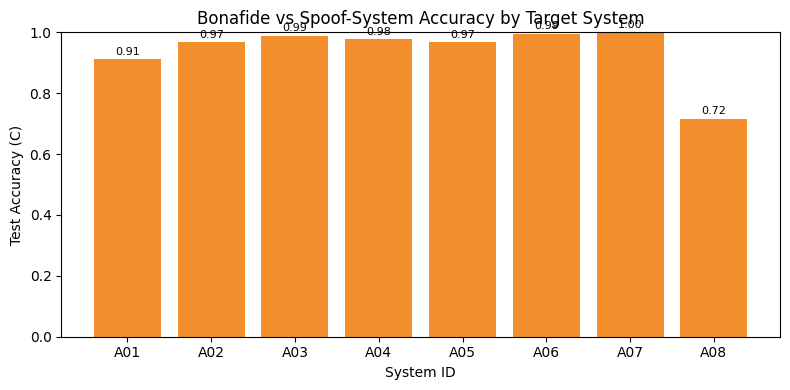

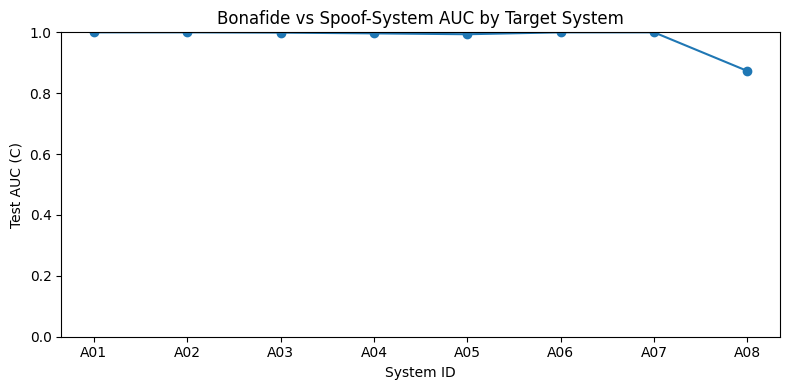

In [7]:
# Visualization: compare systems on test accuracy / test AUC
summary_df = pd.read_csv(OUT_DIR / 'all_systems_metrics_summary.csv')

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(summary_df['target_system'], summary_df['test_accuracy'], color='#f28e2b')
ax.set_ylim(0, 1)
ax.set_xlabel('System ID')
ax.set_ylabel('Test Accuracy (C)')
ax.set_title('Bonafide vs Spoof-System Accuracy by Target System')
for i, v in enumerate(summary_df['test_accuracy']):
    ax.text(i, v + 0.015, f'{v:.2f}', ha='center', fontsize=8)
plt.tight_layout(); plt.show()

if summary_df['test_auc'].notna().any():
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(summary_df['target_system'], summary_df['test_auc'], marker='o')
    ax.set_ylim(0, 1)
    ax.set_xlabel('System ID')
    ax.set_ylabel('Test AUC (C)')
    ax.set_title('Bonafide vs Spoof-System AUC by Target System')
    plt.tight_layout(); plt.show()
